In [1]:
import os
import numpy as np
import xarray as xray
from scipy import io
from scipy import stats
from scipy import linalg as lin
from scipy import signal as sig
from scipy import fftpack as fft
from netCDF4 import Dataset
from scipy import interpolate as naiso

from matplotlib import pyplot as plt
%matplotlib inline

In [24]:
from sstanalysis import pop_spectra
reload(pop_spectra)

<module 'sstanalysis.pop_spectra' from 'sstanalysis/pop_spectra.pyc'>

In [2]:
basedir = '/data/scratch/takaya/POP_data/'

In [3]:
fname_Mar = os.path.join(basedir, 
                         'Surface_Daily/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-03-01.nc')
ex = xray.open_dataset(fname_Mar, decode_times=False)
maskT = ex.KMT > 1
maskU = ex.KMU > 1
latT = ex.TLAT.where(maskT).values
lonT = ex.TLONG.where(maskT).values
latU = ex.ULAT.where(maskU).values
lonU = ex.ULONG.where(maskU).values
dxT = 1e-2 * ex.DXT.where(maskT).values
dyT = 1e-2 * ex.DYT.where(maskT).values
dxU = 1e-2 * ex.DXU.where(maskU).values
dyU = 1e-2 * ex.DYU.where(maskU).values

In [4]:
dz = np.diff(ex.z_t)[0]*1e-2

In [18]:
dlat, dlon = (10., 10.)
lat_start, lat_end = (-60., 50.)
lon_start, lon_end = (5, 345.)
west, south = (lon_start, lat_start)
east, north = (west+dlon, south+dlat)
Degx, Degy = (int((lon_end-lon_start)/dlon), int((lat_end-lat_start)/dlat))
lon_global = np.arange(lon_start, lon_end+2*dlon, dlon)
lat_global = np.arange(lat_start, lat_end+2*dlat, dlat)
Lon_global, Lat_global = np.meshgrid(lon_global, lat_global)

print Degx, Degy, (Degx+1)*(Degy+1)
print Lon_global.shape

34 11 420
(13, 36)


In [20]:
roll = -1080

fname = os.path.join(basedir, 'Surface_Daily/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-02-01.nc')
f = xray.open_dataset(fname, decode_times=False)
mask = f.variables['KMT'].values <= 1
tlon = np.roll(f.variables['TLONG'].where(~mask).values, roll, axis=1)
tlat = np.roll(f.variables['TLAT'].where(~mask).values, roll, axis=1)
Dz = f['dz'].values[0]  # centimeters


lonrange=np.array([lon_start, lon_end])
latrange=np.array([lat_start, lat_end+5.])
lonmask = (tlon >= lonrange[0]) & (tlon < lonrange[1])
latmask = (tlat >= latrange[0]) & (tlat < latrange[1])
boxidx = lonmask & latmask # this won't necessarily be square
irange = np.where(boxidx.sum(axis=0))[0]
imin_bound, imax_bound = irange.min(), irange.max()
jrange = np.where(boxidx.sum(axis=1))[0]
jmin_bound, jmax_bound = jrange.min(), jrange.max()


npzfile = np.load(os.path.join(basedir, 'interpLatnLon.npz'))
print npzfile.files
tlat = npzfile['arr_0']
tlon = npzfile['arr_1']

['arr_1', 'arr_0']


In [7]:
##########
# using PSU, kg, m as units
##########
ocn_ref_salinity = 34.7

rho_fw = 1e3
fwflux_factor = 1e-4
salinity_factor = - ocn_ref_salinity * fwflux_factor * 1e3 * 1e-2   # [(psu*m/s) / (kg/m^2/s)]

cp_sw = 3.996e7
rho_sw = 4.1/3.996
hflux_factor = 1e3 / (rho_sw*cp_sw) / 1e2

# WINTER

In [32]:
#########
month = 1
#########
##########
daystart = 1
daylag = 13
Nmonth = 31
##########
# year = range(34)
# years = np.append(year, range(35,41))
years = range(1)
fname_mat = ['' for x in range(len(years))]

t = 0
for yearnum in years:
    fname = os.path.join(basedir,
                                 'Surface_Daily/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.%04d-%02d-01.nc' 
                                 % (yearnum+46, month))
    fname_mat[t] = fname
    t += 1
    
print fname_mat

mask_global = np.roll(mask, roll, axis=1)[jmin_bound:jmax_bound+100, imin_bound:imax_bound+100]

['/data/scratch/takaya/POP_data/Surface_Daily/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-01-01.nc']


In [33]:
num = 0

for fname in fname_mat:
    
    data = xray.open_dataset(fname, decode_times=False)
    
    Qhf = data.SHF_2.where(maskT)          #"watt/m^2"
    Ffw = data.SFWF_2.where(maskT)     #"kg/m^2/s
    
    Tforc = hflux_factor * Qhf
    Sforc = salinity_factor * Ffw
#     Tforc = xray.DataArray( Tforc, dims=data.SST.dims, coords=data.SST.coords )
#     Sforc = xray.DataArray( Sforc, dims=data.SST.dims, coords=data.SST.coords )
    savename = os.path.join(basedir, 'Tracer_forcing%04d_%02d' % (years[num]+46, month))
    np.savez(savename, Tforc=Tforc, Sforc=Sforc)
    
    num += 1

In [34]:
ex = xray.open_dataset(os.path.join(basedir, 
                                    'Surface_Daily/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-01-01.nc'),
                      decode_times=False)
sst = ex.SST.where(maskT)
sss = ex.SSS.where(maskT)

In [35]:
N=64
crit = 0.01
j,i = (0,0)
west, south = (lon_start, lat_start)
east, north = (west+dlon, south+dlat)

isospecs_month_Tforc = np.zeros((Degy+1, Degx+1, N))
isospecs_month_Sforc = isospecs_month_Tforc.copy()

Kis_month = np.zeros((Degy+1, Degx+1, N))
Mrs_month = np.zeros((Degy+1, Degx+1, N))

In [39]:
for yearnum in years:
    print 'yearnum:', yearnum, 'filename:', fname_mat[yearnum]

#     ###############
#     # convert units to MKS
#     ###############
#     p.nc['U_diss'] = xray.DataArray( 1e-6 * Udiss, dims=p.nc['U1_1'].dims, coords=p.nc['U1_1'].coords )
#     p.nc['V_diss'] = xray.DataArray( 1e-6 * Vdiss, dims=p.nc['V1_1'].dims, coords=p.nc['V1_1'].coords )
    p = pop_spectra.POPFile(fname_mat[yearnum], areaname='TAREA', maskname='KMT', hconst=Dz)
    tracForcnpz = np.load(os.path.join(basedir, 
                                      'Tracer_forcing%04d_%02d.npz' % (yearnum+46, month)))
    Tforc = tracForcnpz['Tforc']
    Sforc = tracForcnpz['Sforc']
    p.nc['Tforc'] = xray.DataArray(Tforc, dims=p.nc['SST'].dims, coords=p.nc['SST'].coords)
    p.nc['Sforc'] = xray.DataArray(Sforc, dims=p.nc['SSS'].dims, coords=p.nc['SSS'].coords)
    
    j = 0
    south = 30.
    north = south + dlat
    while south < 40.:
        print 'j:', j
        west = 155.
        east = west+dlon
        i = 0
        while west < 165.:
            print 'i:', i
#                 print 'i:', i

#                 print east, west, south, north

            lonrange = np.array([west, east])
            latrange = np.array([south, north])
            lonmask = (tlon >= lonrange[0]) & (tlon < lonrange[1])
            latmask = (tlat >= latrange[0]) & (tlat < latrange[1])
            boxidx = lonmask & latmask # this won't necessarily be square
            irange = np.where(boxidx.sum(axis=0))[0]
            imin, imax = irange.min(), irange.max()
            jrange = np.where(boxidx.sum(axis=1))[0]
            jmin, jmax = jrange.min(), jrange.max()
#                 print imin, imax, jmin, jmax

            region_mask = mask_global[jmin:jmax, imin:imax]
            Ny, Nx = region_mask.shape
            land_fraction = region_mask.sum().astype('f8') / (Ny*Nx)
                #SSH_domain = SSH[..., jmin:jmax, imin:imax]
    

            if land_fraction < crit:
                        
                ###########
                # U dissipation
                ###########
                Neff, k, l, Ki, isospec, area = p.iso_wvnum_spectra(
                                                'KMT', 'DXT', 'DYT', False, roll, N, crit,
                                                imin, imax, jmin, jmax, 
                                                jmin_bound, jmax_bound, imin_bound, imax_bound,
                                                daylag, daystart, "SST", "Tforc")
                        
                isospecs_month_Tforc[j, i, :] += isospec[1:]
#                         print 'Temp forcing OK'

                ###########
                # V dissipation
                ###########
                Neff, k, l, Ki, isospec, area = p.iso_wvnum_spectra(
                                                'KMT', 'DXT', 'DYT', False, roll, N, crit,
                                                imin, imax, jmin, jmax, 
                                                jmin_bound, jmax_bound, imin_bound, imax_bound,
                                                daylag, daystart, "SSS", "Sforc")

                isospecs_month_Sforc[j, i, :] += isospec[1:]
                if yearnum == 0:
                    Kis_month[j, i, :] = Ki[1:]
                    Mrs_month[j, i, :] = area
#                         print 'Salinity forcing OK'
               
            else:
                if yearnum == 0:
                    isospecs_month_Tforc[j, i, :] = np.nan
                    isospecs_month_Sforc[j, i, :] = np.nan

                    Kis_month[j, i, :] = np.nan
                    Mrs_month[j, i, :] = np.nan
                        

            west = east
            east = west+dlon
            i += 1
    
        south = north
        north = south+dlat
        j += 1    

yearnum: 0 filename: /data/scratch/takaya/POP_data/Surface_Daily/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-01-01.nc
j: 0
i: 0


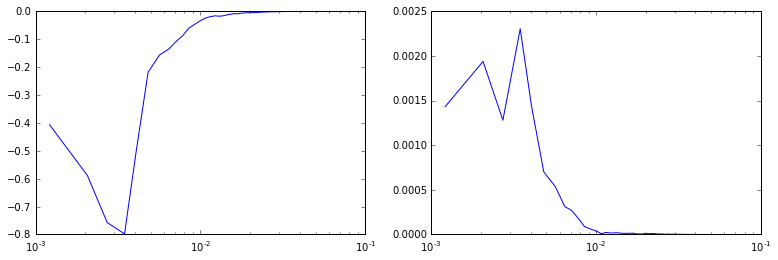

In [40]:
fig = plt.figure(figsize=(13,4))

ax1 = fig.add_subplot(121)
ax1.semilogx(Kis_month[0,0, 1:-1]*1e3, isospecs_month_Tforc[0, 0, 1:-1])

ax2 = fig.add_subplot(122)
ax2.semilogx(Kis_month[0,0, 1:-1]*1e3, isospecs_month_Sforc[0, 0, 1:-1])